## Lab6 - Trees
### Crime Rate Prediction

In [31]:
from IPython.display import Image
import pandas as pd
import subprocess
from sklearn.tree import DecisionTreeClassifier as tree
from sklearn.tree import DecisionTreeRegressor as tree_reg
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor as rf_reg
from operator import itemgetter
from time import time
import numpy as np
import pydotplus

#### In class, we estimated by eye the first split in a classification tree for the following shapely data set. Now let's check to see if our graphical intuition agrees with that of the full classification tree algorithm.

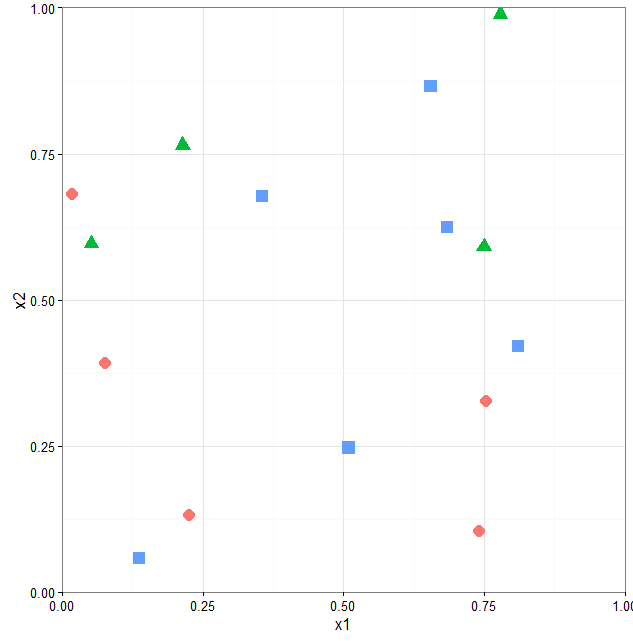

In [32]:
Image("Rplot.png")

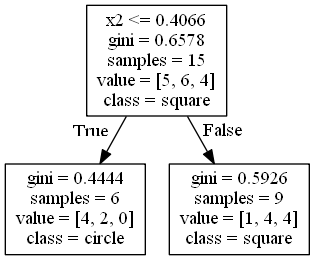

In [33]:
df = pd.read_csv("tree data.csv")
df_X = df.drop(["group"],axis=1)

def visualize_tree(tree, feature_names, class_names, filename):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    dot_data = export_graphviz(tree,out_file=None,feature_names=feature_names, class_names = class_names)
    
    graph = pydotplus.graph_from_dot_data(dot_data)
    
    return(Image(graph.create_png()))

    
t1 = tree(criterion="gini", min_samples_split = 10, min_samples_leaf = 5)
t1.fit(df_X,df["group"])
visualize_tree(t1, df_X.columns,["circle","square","triangle"],"t1")


#### a. The two most common splits that we saw in class were a horizontal split around $X_2 \approx 0.50$ and a vertical split around $X_1 \approx 0.30$. Was either of these the first split decided upon by your classification tree?

Neither of these splits were decided upon. In fact, x1 was not even used oddly enough.

#### b. What is the benefit of the second split in the tree?

There is no benefit, really. The second split has the same prediction for both leaves, square. This likely occurred because splitting there resulted in decreased Gini Index due to decreases in the proportion of the other classes (circle and triangle) to achieve greater nodal purity. However, square still remained the plurality in both groups.

#### c. Which class would this model predict for the new observation with $X_1 = 0.21, X_2 = 0.56$?

Square

#### Now refit the tree based on the *deviance* as the splitting criterion (you set this as an argument to the `tree()` function). The deviance is defined for the classification setting as:

$$ -2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk}$$

#### Plot the resulting tree. Why does this tree differ from the tree fit based on the Gini Index?

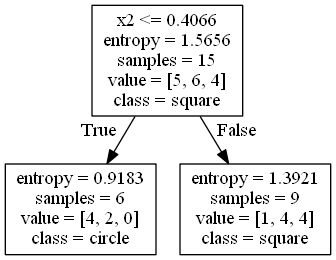

In [34]:
t2 = tree(criterion="entropy", min_samples_split = 10, min_samples_leaf = 5)
t2.fit(df_X,df["group"])
visualize_tree(t2, df_X.columns,["circle","square","triangle"],"t2")


<font color="blue">**R vs Python Note: ** In Python, the gini criteria produced exactly the same tree as the entropy criteria for some reason. This is not the case in R.</font>

#### Crime and Communities, revisited

#### In Lab 3, you fit a regression model to a training data set that predicted the crime rate in a community as a function of properties of that community.

#### 3. Growing a pruned regression tree
#### Fit a regression tree to the *training* data using the default splitting criteria (here, the deviance is essentially the RSS). 

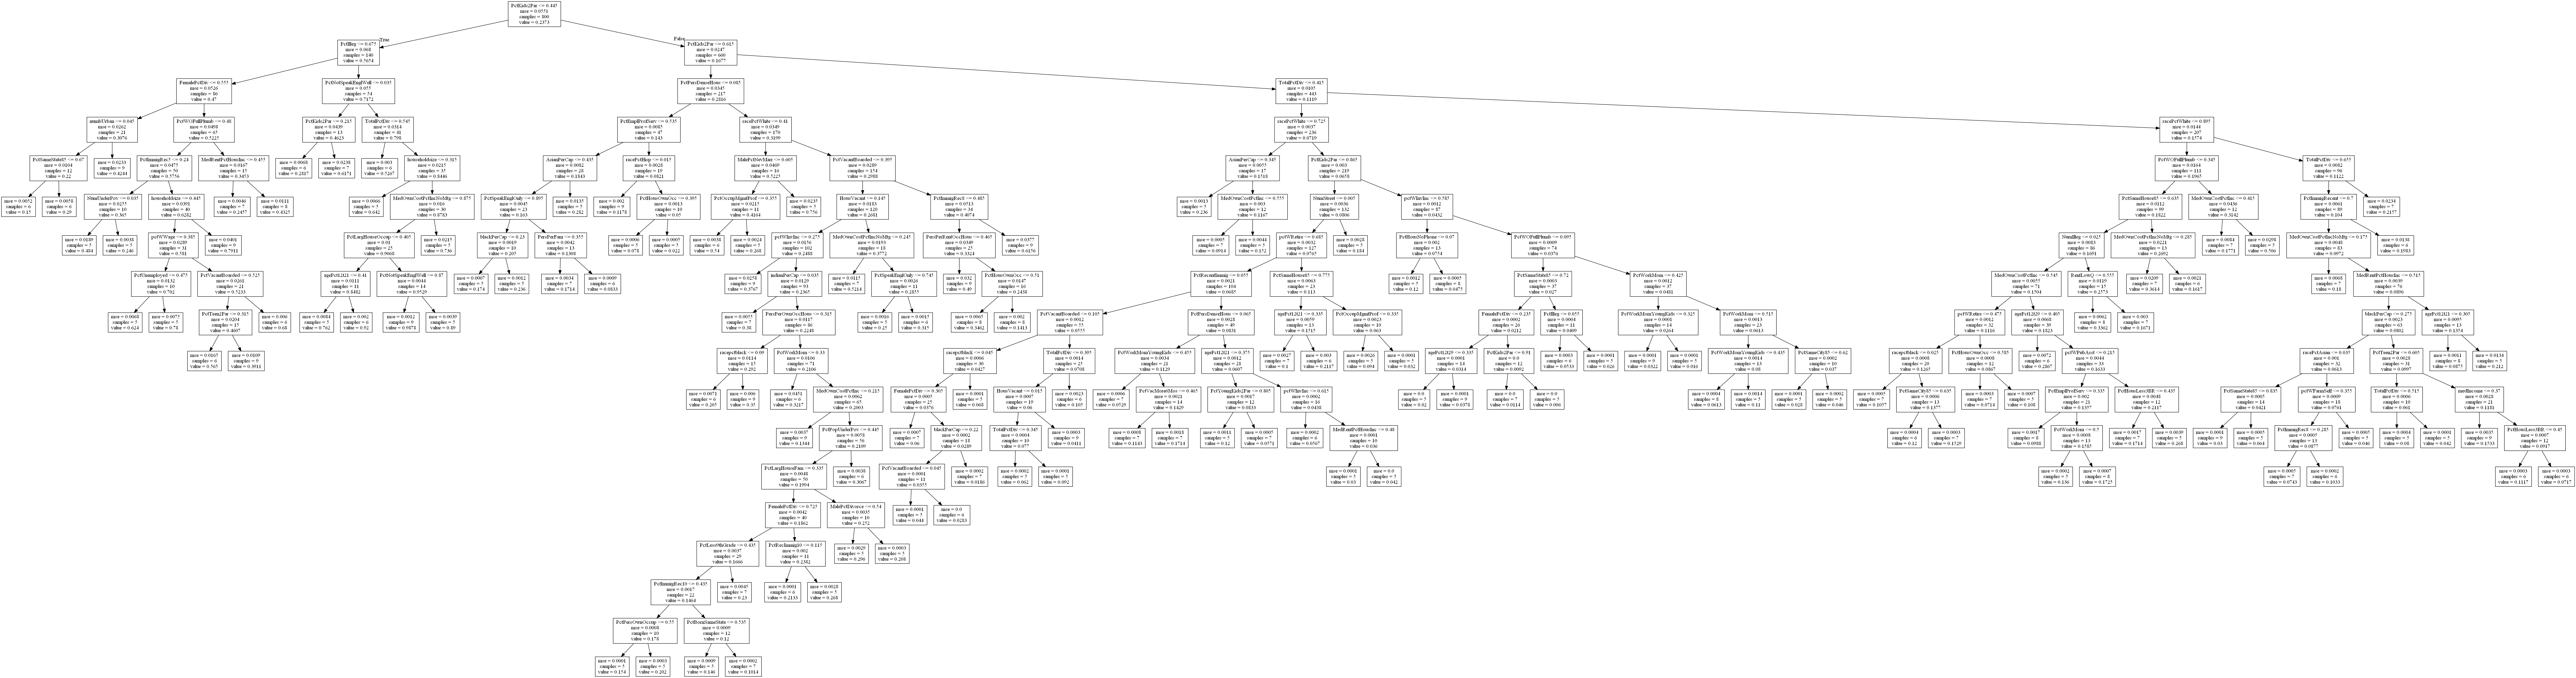

In [35]:
# Import data
crime_train = pd.read_csv("crime-train.csv")
crime_test = pd.read_csv("crime-test.csv")

# Subset the data (getting rid of columns that aren't predictors). Col 127 is our response
crime_train = crime_train.replace("?",np.nan)
crime_train_X = crime_train.iloc[:,5:100]
crime_train_Y = crime_train["ViolentCrimesPerPop"]

crime_test = crime_test.replace("?",np.nan)
crime_test_X = crime_test.iloc[:,5:100]
crime_test_Y = crime_test["ViolentCrimesPerPop"]

# Fit tree with training data
t3 = tree_reg(random_state=76,min_samples_split = 10, min_samples_leaf = 5)
t3.fit(crime_train_X,crime_train_Y)

def visualize_tree_reg(tree, feature_names, filename):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    dot_data = export_graphviz(tree,out_file=None,feature_names=feature_names)
    
    graph = pydotplus.graph_from_dot_data(dot_data)
    
    return(Image(graph.create_png()))
    
visualize_tree_reg(t3,crime_train_X.columns,"t3")

#### Next, perform cost-complexity pruning and generate a plot showing the relationship between tree size and deviance to demonstrate the size of the best tree. Finally, construct the tree diagram for this best tree.

In [42]:
def run_gridsearch(X, y, clf, param_grid, cv=5):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    start = time()
    grid_search.fit(X, y)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(param_grid["max_depth"])))
    
    d = {"params":grid_search.cv_results_['params'],"scores":grid_search.cv_results_['mean_test_score']}
    df = pd.DataFrame(data=d,index=None)
    df.sort_values(by="scores",ascending=False,inplace=True)
    print(df)
    
    return grid_search.best_params_
    
param_grid = {"max_depth": list(range(1,20))}

ts_gs = run_gridsearch(crime_train_X,crime_train_Y,t3,param_grid,cv=10)
print(ts_gs)



GridSearchCV took 4.96 seconds for 19 candidate parameter settings.
               params    scores
2    {'max_depth': 3}  0.519251
3    {'max_depth': 4}  0.495886
1    {'max_depth': 2}  0.472809
4    {'max_depth': 5}  0.462482
5    {'max_depth': 6}  0.436988
6    {'max_depth': 7}  0.423936
7    {'max_depth': 8}  0.405336
8    {'max_depth': 9}  0.396240
9   {'max_depth': 10}  0.393762
10  {'max_depth': 11}  0.393271
11  {'max_depth': 12}  0.392757
13  {'max_depth': 14}  0.388111
12  {'max_depth': 13}  0.386580
14  {'max_depth': 15}  0.386152
15  {'max_depth': 16}  0.386081
17  {'max_depth': 18}  0.386013
18  {'max_depth': 19}  0.386013
16  {'max_depth': 17}  0.386013
0    {'max_depth': 1}  0.360299
{'max_depth': 3}


depth = 3 is the best based on 10-fold cv in Python

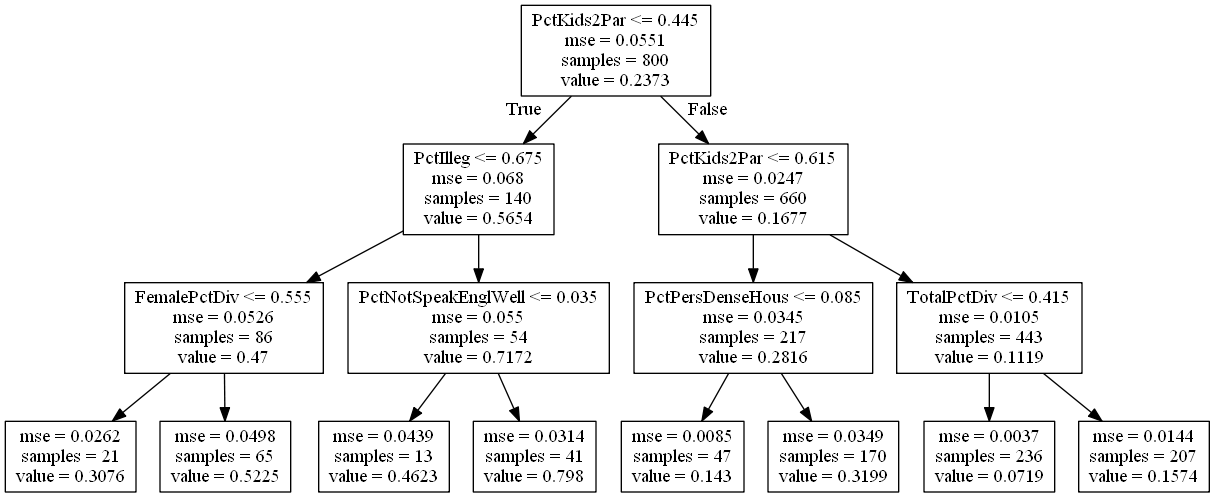

In [43]:
t4 = tree_reg(random_state=76,min_samples_split = 10, min_samples_leaf = 5,max_depth = ts_gs["max_depth"]) 
t4.fit(crime_train_X,crime_train_Y)
visualize_tree_reg(t4,crime_train_X.columns,"t4")

#### 4. Comparing predictive performance
#### Use this tree to compute the MSE for the *test* data set. How does it compare to the test MSE for your regression model?

In [44]:
def mse(tree,test_X,test_Y):
    pred = tree.predict(test_X)
    
    mse = np.mean((pred-test_Y)**2)
    
    return mse
    
pruned_mse = mse(t4,crime_test_X,crime_test_Y)
not_pruned_mse = mse(t3,crime_test_X,crime_test_Y)
print(pruned_mse)
print(not_pruned_mse)

0.024590799837115557
0.03226005343061066


The pruned tree outperforms the unpruned tree meaning that the unpruned tree was potentially overfitting the data. However,
the OLS regression model used in Lab 3 to fit the data outperformed both with an MSE of .019.

#### 5. Growing a random forest
#### We now apply methods to decrease the variance of our estimates. Fit a `randomForest()`  model that performs only bagging and no actual random forests (recall that bagging is the special case of random forests with $m = p$). Next, fit a second random forest model that uses $m = p/3$. Compute their test MSEs. Is this an improvement over the vanilla pruned regression tree? Does it beat your regression model?

In [45]:
# bagging
t5 = rf_reg(random_state=75,n_estimators=500, min_samples_split = 10, min_samples_leaf = 5, max_features=None 
            #use all features for bagging
                )
t5.fit(crime_train_X,crime_train_Y)
bag_mse = mse(t5,crime_test_X,crime_test_Y)
print(bag_mse)

0.017086909570430592


In [46]:
# random forest
t6 = rf_reg(random_state=75, n_estimators=500, min_samples_split = 10, min_samples_leaf = 5, max_features=(1/3))
t6.fit(crime_train_X,crime_train_Y)
rf_mse = mse(t6,crime_test_X,crime_test_Y)
print(rf_mse)



0.016869687789365415


The random forest test model test mse is slightly lower than the bagged model's. Luckily, they both beat the regression model's mse.

#### 6. Variance importance
#### One thing we lose by using these computational techniques to limit the variance is the clearly interpretable tree diagram. We can still salvage some interpretability by considering `importance()`. Please construct a Variable Importance Plot (`varImpPlot()`). Are these results similar/different from your interpretation of your regression coefficients in Lab 3?

In [47]:
def implist(model,features,ascending=False):
    l = pd.DataFrame()
    l["features"] = features
    l["importance"] = model.feature_importances_
    l.sort_values(by="importance",axis=0,inplace=True,ascending=ascending)
    
    
    return l
    
implist(t6,crime_train_X.columns)

,features,importance
43,PctKids2Par,0.217056
49,PctIlleg,0.162358
2,racePctWhite,0.066090
48,NumIlleg,0.065386
42,PctFam2Par,0.060862
44,PctYoungKids2Par,0.031556
1,racepctblack,0.020819
67,PctPersDenseHous,0.020210
45,PctTeen2Par,0.020014
40,TotalPctDiv,0.017320


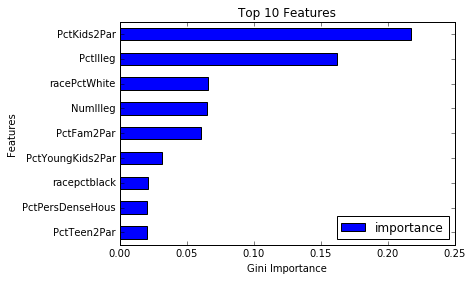

In [48]:
%matplotlib inline
def impplot(model,features,ascending=False,n=10):
    l = implist(model,features,ascending)
    lsub = l.iloc[0:n-1,].copy()
    lsub.sort_values(by="importance",axis=0,inplace=True,ascending=True)
    ax = lsub.plot(kind="barh",x="features",y="importance")
    ax.set_ylabel("Features")
    ax.set_xlabel("Gini Importance")
    ax.set_title("Top " + str(n) + " Features")
    
impplot(t6,crime_train_X.columns)

<font color="blue">**R vs Python Note: **Note: Scikit-Learn only measures importance by Gini and not by Mean Decrease Accuracy which R does</font>

When we discussed Lab 3 race was often brought up as the most important predictor in the data set. Here that is recognized 
by the use of `racePctWhite` which is in the top five most important predictors. However some variables while included in
 our labs, were not discussed in the classroom much. For example, the family units were not properly accounted for as 
 `PctKids2Par`, `PctIlleg`, `NumIlleg`, and `TotalPctDiv` are all highly important variables (there are even more family 
 related variables that are important that aren't listed here because they exist in the importance plot above). So while 
 some labs did include the family predictors their importance wasn't acknowledged and was downplayed compared to the racial 
 predictors. These racial predictors are still explanatory, but they aren't as powerful as the family predictors.